In [168]:
import torch
import torch.nn.functional as F
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from torch import nn
from tqdm import tqdm
from matplotlib import cm

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

100.0%
100.0%
100.0%
100.0%


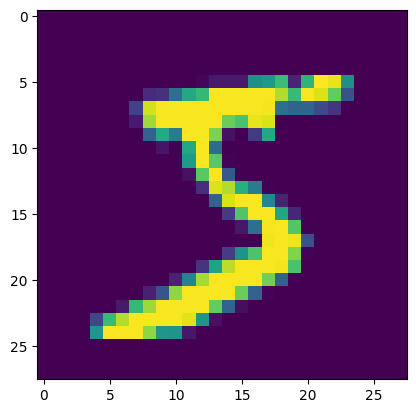

In [10]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [11]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [13]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 395.31it/s]


Epoch: 0, loss: 0.3202912509441376, accuracy: 0.91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 400.04it/s]


Epoch: 2, loss: 0.2328818291425705, accuracy: 0.9314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 401.83it/s]

Epoch: 4, loss: 0.18696078658103943, accuracy: 0.9462


In [14]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [15]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 283.78it/s]


Epoch: 0, loss: 0.26601409912109375, accuracy: 0.9248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 272.62it/s]


Epoch: 2, loss: 0.12715715169906616, accuracy: 0.9627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 286.19it/s]

Epoch: 4, loss: 0.08613914251327515, accuracy: 0.9745


In [20]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5,
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
    ),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

transform_val = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [21]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform_train
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform_val
)

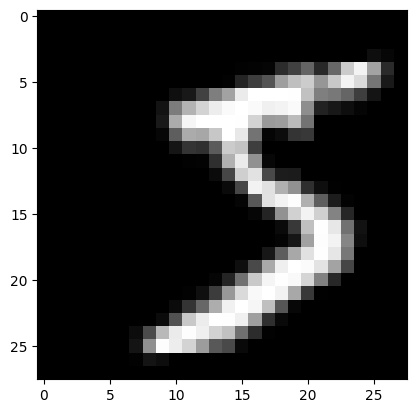

In [37]:
plt.imshow(mnist_train[0][0].numpy().reshape([28, 28]), cmap='gray')

In [131]:
def train(model, optimizer, n_epochs=5, loss_function=nn.MultiMarginLoss(margin=1.0, reduction='mean')):
    for epoch in range(n_epochs):
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = loss_function(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [132]:
#другой оптимизатор и лосс
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 47,758


In [133]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 237.98it/s]


Epoch: 0, loss: 0.21359668672084808, accuracy: 0.969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 261.19it/s]


Epoch: 2, loss: 0.10166880488395691, accuracy: 0.9808


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 232.75it/s]

Epoch: 4, loss: 0.07489483803510666, accuracy: 0.985


In [134]:
#увеличим количество выходных каналов свертки
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 94,098


In [135]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 189.38it/s]


Epoch: 0, loss: 0.1672743409872055, accuracy: 0.9791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 206.25it/s]


Epoch: 2, loss: 0.10396522283554077, accuracy: 0.984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 194.20it/s]

Epoch: 4, loss: 0.0790247917175293, accuracy: 0.9845


In [139]:
#модель начала запоминать шум - точность немного снизилась. нет необходимости в 20 фильтрах

In [137]:
#уменьшим количество выходных каналов свертки
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*5, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 24,588


In [138]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 304.63it/s]


Epoch: 0, loss: 0.22759169340133667, accuracy: 0.9659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 238.41it/s]


Epoch: 2, loss: 0.15683259069919586, accuracy: 0.9743


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 290.80it/s]

Epoch: 4, loss: 0.10340183973312378, accuracy: 0.9798


In [ ]:
#точность снизилась - 5 выходов недостаточно

In [140]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=15, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*15, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 70,928


In [141]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 218.09it/s]


Epoch: 0, loss: 0.17434196174144745, accuracy: 0.9758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 222.93it/s]


Epoch: 2, loss: 0.09576746821403503, accuracy: 0.9852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 232.22it/s]

Epoch: 4, loss: 0.06888668984174728, accuracy: 0.9879


In [142]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*16, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 75,562


In [143]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 227.06it/s]


Epoch: 0, loss: 0.18652339279651642, accuracy: 0.9764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 222.49it/s]


Epoch: 2, loss: 0.0998249277472496, accuracy: 0.9858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 223.77it/s]

Epoch: 4, loss: 0.07380279153585434, accuracy: 0.9873


In [144]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=14, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*14, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 66,294


In [145]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 222.07it/s]


Epoch: 0, loss: 0.188644140958786, accuracy: 0.9739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 204.45it/s]


Epoch: 2, loss: 0.10117743164300919, accuracy: 0.9847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 222.96it/s]

Epoch: 4, loss: 0.07599576562643051, accuracy: 0.9861


In [146]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=13, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*13, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 61,660


In [147]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 222.05it/s]


Epoch: 0, loss: 0.20293082296848297, accuracy: 0.9779


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 232.41it/s]


Epoch: 2, loss: 0.11146063357591629, accuracy: 0.9812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 237.65it/s]

Epoch: 4, loss: 0.07303640991449356, accuracy: 0.9862


In [ ]:
#оптимальное количество выходных каналов - 15. Лучший результат: loss: 0.06888668984174728, accuracy: 0.9879

In [151]:
#уменьшим размер фильтра свертки
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=14, kernel_size=3), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*14, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 66,070


In [152]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 253.45it/s]


Epoch: 0, loss: 0.26174795627593994, accuracy: 0.9653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 229.56it/s]


Epoch: 2, loss: 0.14910978078842163, accuracy: 0.9759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 253.72it/s]

Epoch: 4, loss: 0.09928978234529495, accuracy: 0.9845


In [ ]:
#На MNIST цифры относительно крупные, гладкие формы (круги, линии, дуги). Ядро 5*5 видит чать цифры целиком, поэтому та модель лучше

In [153]:
#увеличим размер фильтра свертки
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=14, kernel_size=9), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(5*5*14, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 47,366


In [154]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 228.82it/s]


Epoch: 0, loss: 0.186069056391716, accuracy: 0.9715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 206.09it/s]


Epoch: 2, loss: 0.08233080059289932, accuracy: 0.9856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 232.07it/s]

Epoch: 4, loss: 0.07469266653060913, accuracy: 0.9834


In [ ]:
#переобучились

In [156]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=14, kernel_size=7), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(11*11*14, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 218,950


In [157]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 181.41it/s]


Epoch: 0, loss: 0.12756001949310303, accuracy: 0.9809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 184.16it/s]


Epoch: 2, loss: 0.07805520296096802, accuracy: 0.9839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 208.06it/s]

Epoch: 4, loss: 0.05435327813029289, accuracy: 0.9867


In [158]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=18, kernel_size=7), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(11*11*18, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 281,102


In [159]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 187.52it/s]


Epoch: 0, loss: 0.13151681423187256, accuracy: 0.9802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 188.66it/s]


Epoch: 2, loss: 0.06290559470653534, accuracy: 0.9866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 144.07it/s]

Epoch: 4, loss: 0.049126073718070984, accuracy: 0.9875


In [160]:
#близко к наилучшему результату - крупный фильтр свертки, небольшой фильтр пулинга, большое количество выходных каналов.
#свертка позволяет распознать цифру "целиком", а слабый пулинг сохраняет детали
#Epoch: 4, loss: 0.049126073718070984, accuracy: 0.9875

In [163]:
#добавим stride. предположение - увеличит скорость обучения, т.к. уменьшит количество параметров обучения
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=18, kernel_size=7, stride=3), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4*4*18, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {total_params:,}")

Количество обучаемых параметров: 39,182


In [162]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 289.17it/s]


Epoch: 0, loss: 0.211610347032547, accuracy: 0.9714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 284.26it/s]


Epoch: 2, loss: 0.11353234201669693, accuracy: 0.9807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 244.93it/s]

Epoch: 4, loss: 0.08246183395385742, accuracy: 0.9852


In [ ]:
#Таким образом, наилучший полученный результат по accuracy: 0.9879 при параметрах out_chanel=13, conv_kernel_size=5, pool_kernel_size=4
#по loss: 0.049126073718070984 при параметрах out_chanel=18, conv_kernel_size=7, pool_kernel_size=2

In [175]:
def train_with_logging(model, optimizer, n_epochs=5, plot=True, loss_function=nn.MultiMarginLoss(margin=1.0, reduction='mean')):
    train_loss_epochs = []
    train_accuracy_epochs = []
    val_loss_epochs = []
    val_accuracy_epochs = []
    for epoch in range(n_epochs):

        train_losses = []
        train_accuracies = []
        for x_train, y_train in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]', leave=False):
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = loss_function(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_accuracies.extend((torch.argmax(y_pred, dim=-1) == y_train).cpu().numpy().tolist())
        train_loss_epochs.append(np.mean(train_losses))
        train_accuracy_epochs.append(np.mean(train_accuracies))
        if epoch % 2 == 0:
            val_losses = []
            val_accuracies = []
            model.eval() 
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{n_epochs} [Val]', leave=False):
                    y_pred = model(x_val)
                    loss = loss_function(y_pred, y_val)
                    val_losses.append(loss.item())
                    val_accuracies.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())
            val_loss_epochs.append(np.mean(val_losses))
            val_accuracy_epochs.append(np.mean(val_accuracies))
            print(f'Epoch: {epoch}, '
                  f'Train Loss: {train_loss_epochs[-1]:.4f}, '
                  f'Train Acc: {train_accuracy_epochs[-1]:.4f}, '
                  f'Val Loss: {val_loss_epochs[-1]:.4f}, '
                  f'Val Acc: {val_accuracy_epochs[-1]:.4f}')
    if plot:
        epochs_range = list(range(n_epochs))
        val_epochs = list(range(0, n_epochs, 2))
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_loss_epochs, label='Train Loss', color='blue', linewidth=2)
        plt.plot(val_epochs, val_loss_epochs, label='Val Loss', color='red', linewidth=2, marker='o')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('Loss over Epochs', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accuracy_epochs, label='Train Accuracy', color='blue', linewidth=2)
        plt.plot(val_epochs, val_accuracy_epochs, label='Val Accuracy', color='red', linewidth=2, marker='o')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.title('Accuracy over Epochs', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    return train_loss_epochs, val_loss_epochs, train_accuracy_epochs, val_accuracy_epochs

In [176]:
results = {}

Epoch: 0, Train Loss: 0.0323, Train Acc: 0.9366, Val Loss: 0.0120, Val Acc: 0.9678


Epoch: 2, Train Loss: 0.0063, Train Acc: 0.9817, Val Loss: 0.0049, Val Acc: 0.9842


Epoch: 4, Train Loss: 0.0040, Train Acc: 0.9876, Val Loss: 0.0057, Val Acc: 0.9826


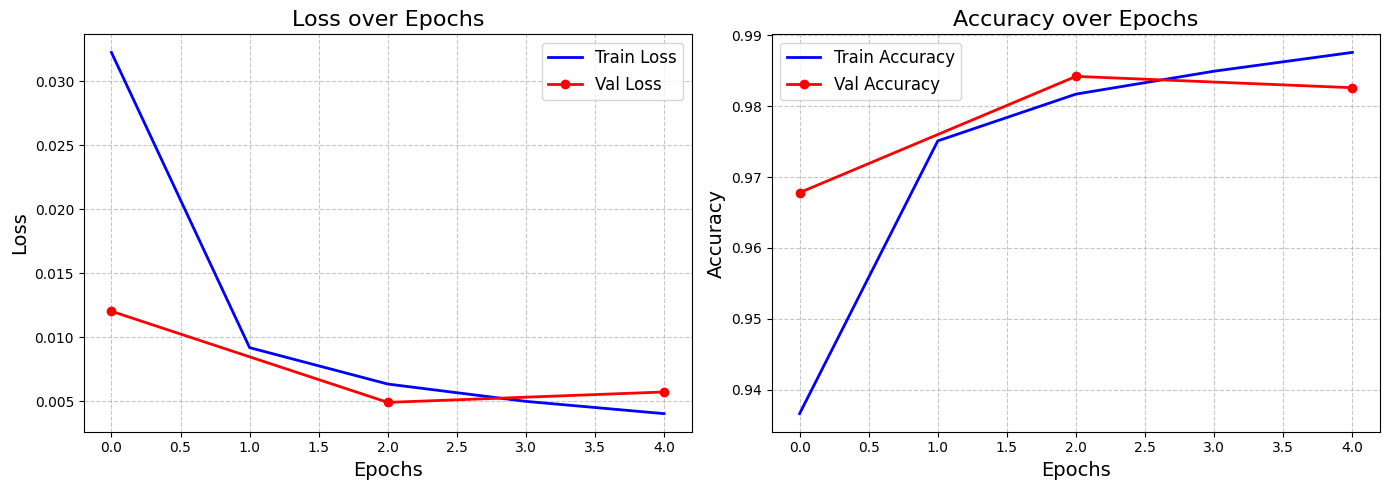

In [177]:
model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=13, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*13, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.001)
result1 = train_with_logging(model1, optimizer1)
results["1"] = result1

Epoch: 0, Train Loss: 0.0225, Train Acc: 0.9512, Val Loss: 0.0081, Val Acc: 0.9763


Epoch: 2, Train Loss: 0.0044, Train Acc: 0.9863, Val Loss: 0.0066, Val Acc: 0.9831


Epoch: 4, Train Loss: 0.0027, Train Acc: 0.9908, Val Loss: 0.0038, Val Acc: 0.9879


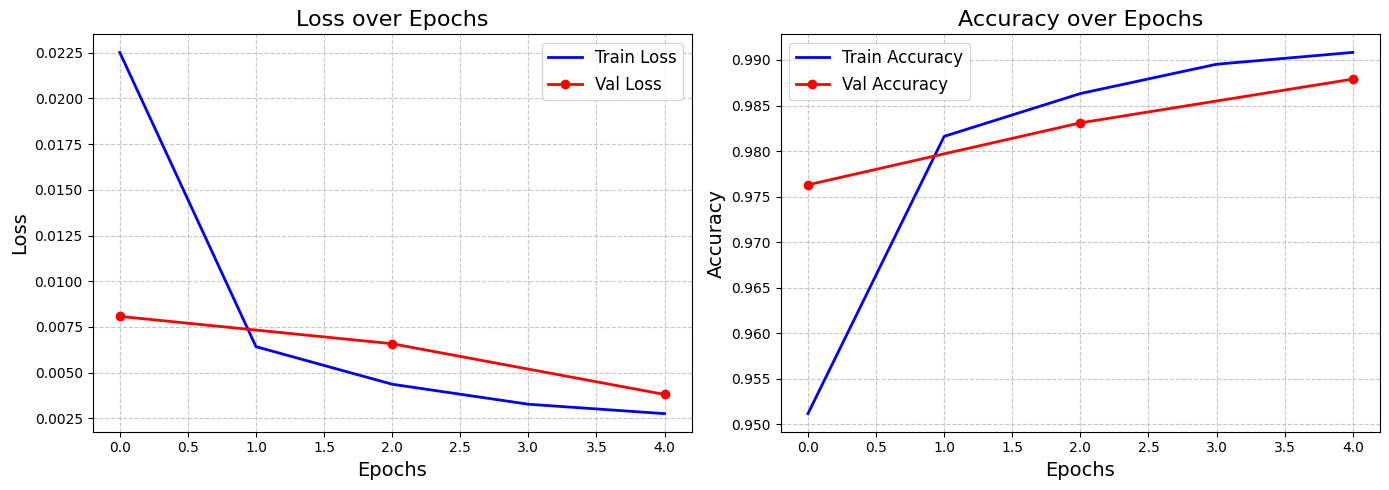

In [178]:
model2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=18, kernel_size=7), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(11*11*18, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.001)
result2 = train_with_logging(model2, optimizer2)
results["2"] = result2

Epoch: 0, Train Loss: 0.0290, Train Acc: 0.9443, Val Loss: 0.0121, Val Acc: 0.9651


Epoch: 2, Train Loss: 0.0061, Train Acc: 0.9820, Val Loss: 0.0049, Val Acc: 0.9849


Epoch: 4, Train Loss: 0.0040, Train Acc: 0.9878, Val Loss: 0.0053, Val Acc: 0.9843


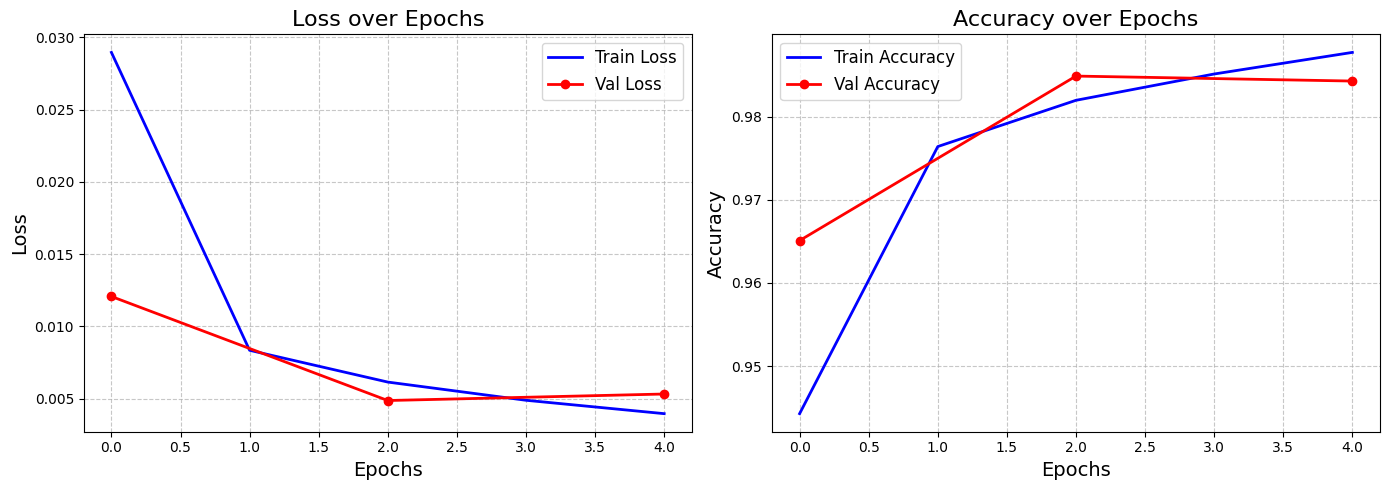

In [179]:
model3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=14, kernel_size=9), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(5*5*14, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=0.001)
result3 = train_with_logging(model3, optimizer3)
results["3"] = result3

In [180]:
def plot_all_models_comparison(results_dict, title="Comparison of All Models"):
    colors = ['blue', 'green', 'red']
    markers = ['o', 's', '^']
    model_names = list(results_dict.keys())

    plt.figure(figsize=(16, 6))

    # Loss
    plt.subplot(1, 2, 1)
    for i, (name, metrics) in enumerate(results_dict.items()):
        train_loss, val_loss, _, _ = metrics
        epochs = list(range(len(train_loss)))
        val_epochs = list(range(0, len(train_loss), 2))
        plt.plot(epochs, train_loss, label=f'Model {name} (Train)', color=colors[i], linewidth=2, alpha=0.8)
        plt.plot(val_epochs, val_loss, label=f'Model {name} (Val)', color=colors[i], linestyle='--', linewidth=2, marker=markers[i], markersize=6, alpha=0.9)
    plt.title('Loss Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Accuracy
    plt.subplot(1, 2, 2)
    for i, (name, metrics) in enumerate(results_dict.items()):
        _, _, train_acc, val_acc = metrics
        epochs = list(range(len(train_acc)))
        val_epochs = list(range(0, len(train_acc), 2))
        plt.plot(epochs, train_acc, label=f'Model {name} (Train)', color=colors[i], linewidth=2, alpha=0.8)
        plt.plot(val_epochs, val_acc, label=f'Model {name} (Val)', color=colors[i], linestyle='--', linewidth=2, marker=markers[i], markersize=6, alpha=0.9)
    plt.title('Accuracy Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(title, fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

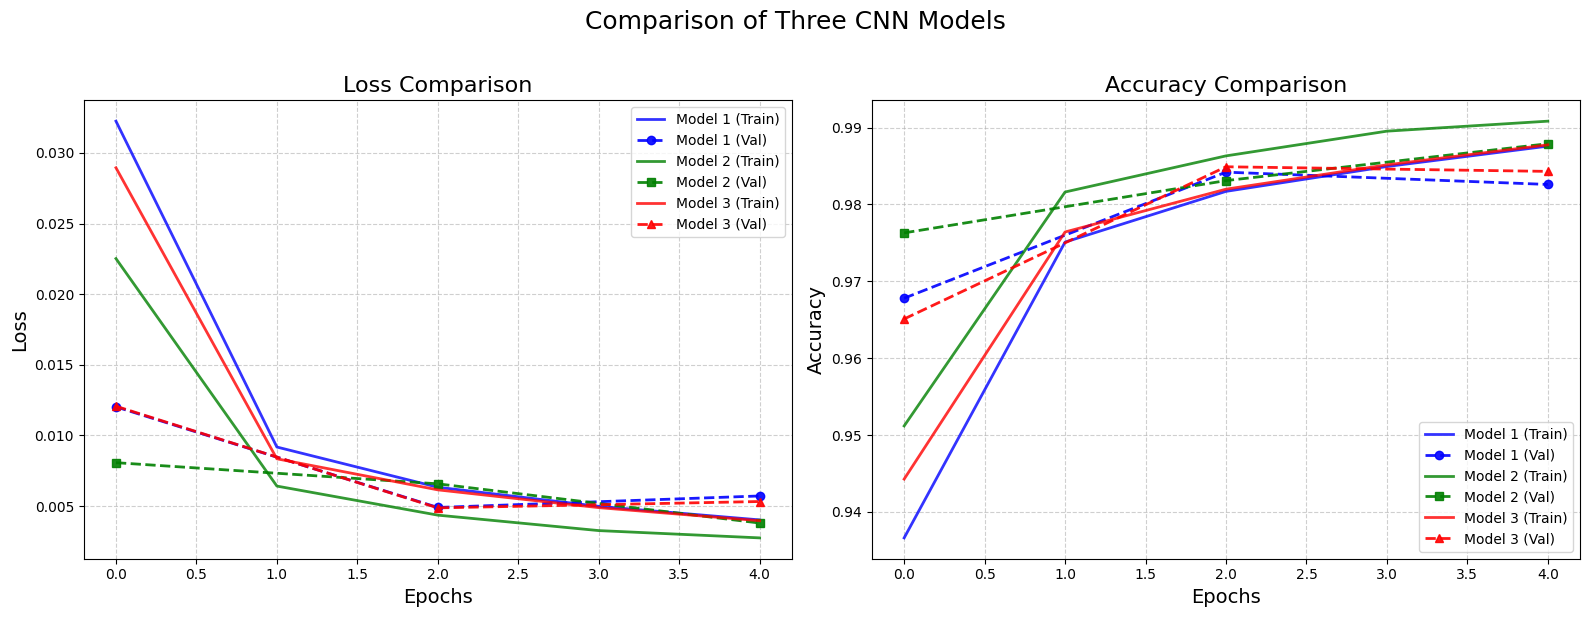

In [181]:
plot_all_models_comparison(results, "Comparison of Three CNN Models")

In [60]:
#LeNet
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(4*4*16, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [61]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 221.56it/s]


Epoch: 0, loss: 0.15529470145702362, accuracy: 0.961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 251.85it/s]


Epoch: 2, loss: 0.15921641886234283, accuracy: 0.9527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 245.09it/s]

Epoch: 4, loss: 0.12085559964179993, accuracy: 0.9632


In [ ]:
accuracy падает, а loss растет - переобучение. Уменьшу learning rate

In [45]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(4*4*16, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [46]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 244.81it/s]


Epoch: 0, loss: 0.07475525885820389, accuracy: 0.9759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 255.67it/s]


Epoch: 2, loss: 0.051870521157979965, accuracy: 0.9834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 256.81it/s]

Epoch: 4, loss: 0.03385557234287262, accuracy: 0.989


In [ ]:
Попробую использовать ReLU() в качесте функции активации, чтобы не ограничивать выходной диапазон. 
Возможно, это положительно повлияет на maxPool.

In [49]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(4*4*16, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [50]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 282.71it/s]


Epoch: 0, loss: 0.06215253472328186, accuracy: 0.9807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 285.15it/s]


Epoch: 2, loss: 0.04365142434835434, accuracy: 0.9864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 282.61it/s]

Epoch: 4, loss: 0.04272779822349548, accuracy: 0.9868


In [ ]:
Relu учится быстрее, но требует регуляризации, чтобы не терять обобщающую способность, эпока 2-4 идет тренд на переобучение

In [56]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(4*4*16, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [57]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 276.47it/s]


Epoch: 0, loss: 0.06529738754034042, accuracy: 0.9805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 279.83it/s]


Epoch: 2, loss: 0.04175448417663574, accuracy: 0.9861


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 281.76it/s]

Epoch: 4, loss: 0.03168555721640587, accuracy: 0.9904


In [182]:
0.9904

0.9904